## Basic RAG

**RAG (Retrieval-Augmented Generation)** es una técnica que combina modelos de lenguaje con recuperación de información para responder preguntas o generar texto utilizando datos externos. En lugar de depender únicamente del conocimiento aprendido durante el entrenamiento, RAG primero busca información relevante en bases de datos, documentos o motores de búsqueda, y luego la utiliza como contexto para generar respuestas más precisas y actualizadas.

El flujo típico de RAG consta de dos etapas: **(1) Recuperación**, donde una consulta se usa para buscar textos relevantes en una fuente externa (como un índice vectorial o base documental), y **(2) Generación**, donde un modelo de lenguaje utiliza esos textos recuperados como contexto para crear una respuesta coherente e informada. Esto permite mejorar la precisión, reducir alucinaciones y aprovechar información dinámica sin necesidad de reentrenar el modelo.

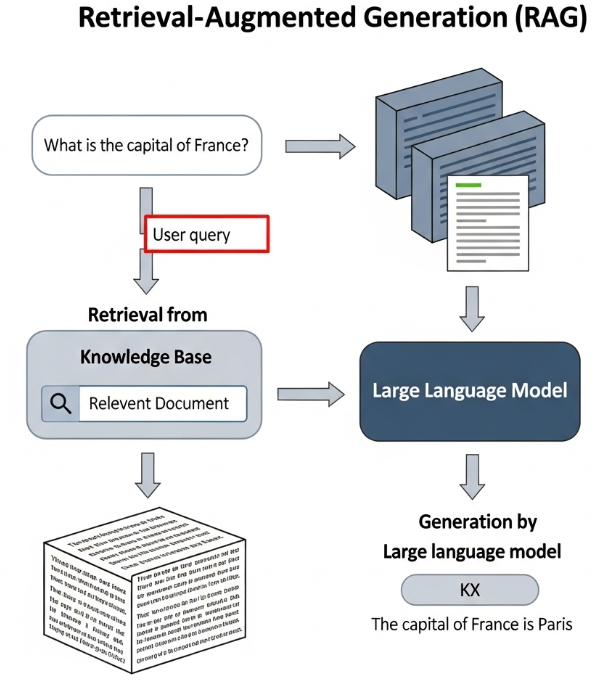

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
     
if not os.getenv("OPENAI_API_KEY"):
    print("Error: La variable de entorno OPENAI_API_KEY no está definida.")

print("OPENAI_API_KEY cargada correctamente.")

OPENAI_API_KEY cargada correctamente.


Obtención de los datos

In [4]:
import requests 

docs_url = 'https://github.com/alexeygrigorev/llm-rag-workshop/raw/main/notebooks/documents.json'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

Indexar los datos a minsearch

In [31]:
from minsearch import AppendableIndex

index = AppendableIndex(
    text_fields=["question", "text", "section"],
    keyword_fields=["course"]
)

index.fit(documents)

Metodo para la busqueda de información

In [5]:
def search(query):
    boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query=query,
        filter_dict={'course': 'data-engineering-zoomcamp'},
        boost_dict=boost,
        num_results=5,
        output_ids=True
    )

    return results

Metodo para construir nuestro promt

In [6]:
prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

<QUESTION>
{question}
</QUESTION>

<CONTEXT>
{context}
</CONTEXT>
""".strip()

def build_prompt(query, search_results):
    context = ""

    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [9]:
from openai import OpenAI
client = OpenAI()

def llm(prompt):
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

Flujo principal del RAG

In [11]:
def rag(query):
    search_results = search(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [17]:
response = rag("How to run Docker in WSL")

In [18]:
print(response)

To run Docker in WSL, follow these steps:

1. Ensure you are using WSL2, which is available for Windows 10/11 Home Edition. If you're using a Home Edition, refer to the tutorial provided in the documentation for setting up WSL2.
2. Remember that on Windows 10 Pro/11 Pro, Docker can leverage Hyper-V, but Home users should only use WSL2.
3. If you encounter issues with Docker being stuck, consider resetting to factory defaults or performing a fresh install.
4. Always run Docker commands from the WSL file system rather than the Windows file system to avoid permissions conflicts.
5. If you face any permissions errors, utilize Docker volumes for storage, as this resolves permission issues and enhances volume management.

For more detailed instructions, consult the specific tutorial linked in the official Docker documentation for WSL installation.


## Agentic RAG

Ahora hagamos que nuestro flujo sea agente. 
Los agentes son sistemas de IA que pueden:

- Tomar decisiones sobre qué acciones llevar a cabo
- Utilice herramientas para realizar tareas
- Mantener el estado y el contexto
- Aprenda de interacciones anteriores
- Trabajar hacia objetivos específicos

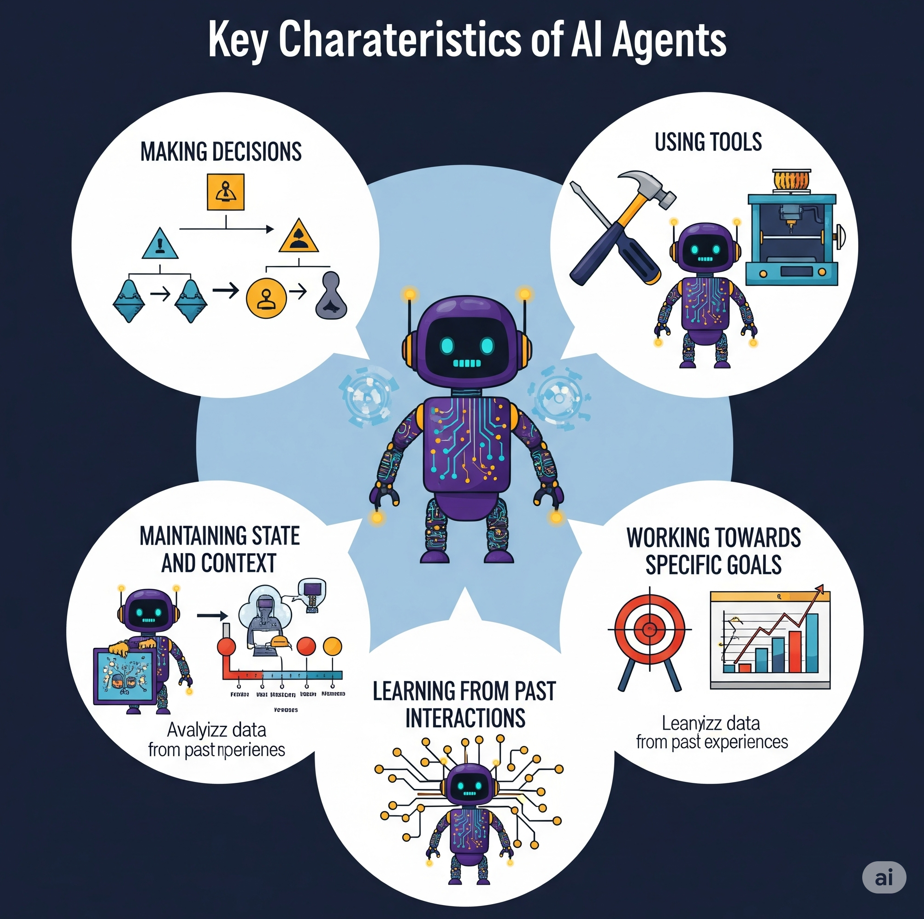

El flujo agente no es necesariamente un agente completamente independiente, pero aún puede tomar algunas decisiones durante la ejecución del flujo.

Un flujo agente típico consta de:
- Recibir una solicitud de usuario
- Analizando la solicitud y las herramientas disponibles
- Decidir la siguiente acción
- Ejecutar la acción utilizando herramientas adecuadas
- Evaluación de los resultados
- Ya sea completando la tarea o continuando con más acciones

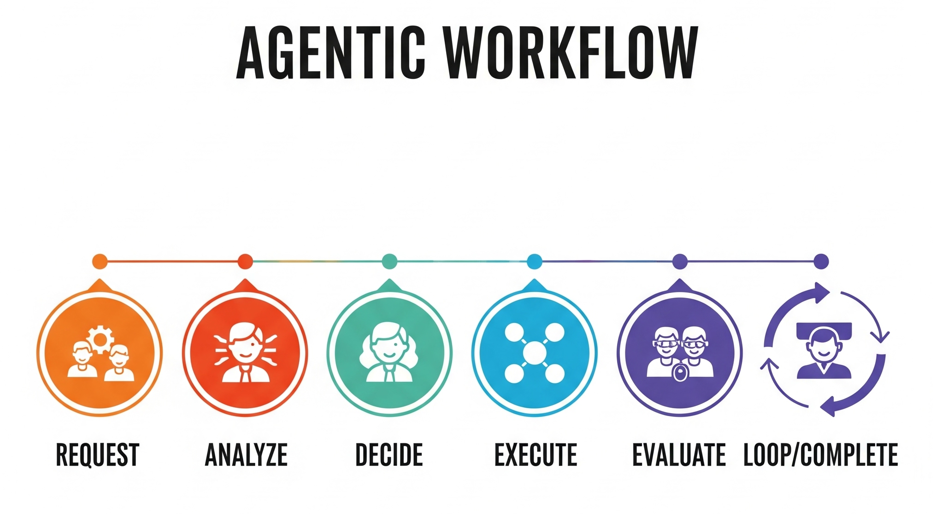

La diferencia clave con el RAG básico es que los agentes pueden:
- Realizar múltiples consultas de búsqueda
- Combinar información de diferentes fuentes
- Decide cuándo dejar de buscar
- Utilizar sus propios conocimientos cuando sea apropiado
- Encadenar múltiples acciones juntas

Entonces, en RAG agente, el sistema
- tiene acceso al historial de acciones anteriores
- toma decisiones de forma independiente basándose en la información actual y las acciones previas

*Implementemos esto paso a paso.*

### Haciendo que RAG sea más agente
Primero, tomaremos el mensaje que tenemos hasta ahora y lo haremos un poco más "agentético":
- Dígale al LLM que puede responder la pregunta directamente o buscar el contexto
- Proporcionar plantillas de salida
- Muestra claramente cuál es la fuente de la respuesta.

In [20]:
prompt_template = """
You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.
At the beginning the context is EMPTY.

<QUESTION>
{question}
</QUESTION>

<CONTEXT> 
{context}
</CONTEXT>

If CONTEXT is EMPTY, you can use our FAQ database.
In this case, use the following output template:

{{
"action": "SEARCH",
"reasoning": "<add your reasoning here>"
}}

If you can answer the QUESTION using CONTEXT, use this template:

{{
"action": "ANSWER",
"answer": "<your answer>",
"source": "CONTEXT"
}}

If the context doesn't contain the answer, use your own knowledge to answer the question

{{
"action": "ANSWER",
"answer": "<your answer>",
"source": "OWN_KNOWLEDGE"
}}
""".strip()

Este `prompt_template` está diseñado para guiar a un modelo de lenguaje que actúa como un **asistente de enseñanza** de un curso. Su propósito es ayudar a responder preguntas de estudiantes utilizando una lógica estructurada, ya sea con información proporcionada (contexto), una base de datos de preguntas frecuentes (FAQ) o el propio conocimiento del modelo.

#### ¿Qué hace este prompt?

1. **Define el rol del modelo:** Se le indica que es un *teaching assistant* y que debe responder preguntas usando su conocimiento y el bloque de `CONTEXT`.

2. **Organiza la entrada:** La pregunta del estudiante (`{question}`) y el contexto (`{context}`) se incluyen dentro de bloques etiquetados `<QUESTION>` y `<CONTEXT>`.

3. **Lógica de decisión:**
   - Si `CONTEXT` está vacío, el modelo debe consultar una base de datos FAQ y devolver la siguiente estructura:
     ```json
     {
       "action": "SEARCH",
       "reasoning": "<explicación de por qué va a buscar>"
     }
     ```
   - Si la respuesta está en el `CONTEXT`, debe usarlo y responder así:
     ```json
     {
       "action": "ANSWER",
       "answer": "<respuesta>",
       "source": "CONTEXT"
     }
     ```
   - Si el contexto no tiene la respuesta, pero el modelo puede responder con su conocimiento interno:
     ```json
     {
       "action": "ANSWER",
       "answer": "<respuesta>",
       "source": "OWN_KNOWLEDGE"
     }
     ```

#### En resumen

Este prompt proporciona una estructura clara para que el modelo decida **cuándo buscar información**, **cuándo usar contexto externo**, y **cuándo usar su propio conocimiento**, devolviendo siempre una respuesta en un formato JSON fácil de procesar.


Vamos a realizar unas pruebas

In [25]:
question = "how do I run docker on gentoo?"
context = "EMPTY"

prompt = prompt_template.format(question=question, context=context)
print(prompt)

print("="*100)
answer = llm(prompt)
print(answer)

You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.
At the beginning the context is EMPTY.

<QUESTION>
how do I run docker on gentoo?
</QUESTION>

<CONTEXT> 
EMPTY
</CONTEXT>

If CONTEXT is EMPTY, you can use our FAQ database.
In this case, use the following output template:

{
"action": "SEARCH",
"reasoning": "<add your reasoning here>"
}

If you can answer the QUESTION using CONTEXT, use this template:

{
"action": "ANSWER",
"answer": "<your answer>",
"source": "CONTEXT"
}

If the context doesn't contain the answer, use your own knowledge to answer the question

{
"action": "ANSWER",
"answer": "<your answer>",
"source": "OWN_KNOWLEDGE"
}
{
"action": "ANSWER",
"answer": "To run Docker on Gentoo, you can follow these general steps: 1. **Install Docker**: First, you need to install Docker. You can do this by running the command `emerge app-emulation/docker` in the terminal. Make sure

In [26]:
question = "how do I join the course?"
context = "EMPTY"

prompt = prompt_template.format(question=question, context=context)
answer = llm(prompt)
print(answer)

{
"action": "SEARCH",
"reasoning": "The context is empty, so I need to look up the procedure for joining the course in our FAQ database."
}


Creamos una funcion para devolver en contexto

In [27]:
def build_context(search_results):
    context = ""

    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"

    return context.strip()

Usamo el metodo que creamos recien para ver la respuesta del LLM

In [28]:
search_results = search(question)
context = build_context(search_results)
prompt = prompt_template.format(question=question, context=context)
print(prompt)

You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.
At the beginning the context is EMPTY.

<QUESTION>
how do I join the course?
</QUESTION>

<CONTEXT> 
section: General course-related questions
question: Course - Can I still join the course after the start date?
answer: Yes, even if you don't register, you're still eligible to submit the homeworks.
Be aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.

section: General course-related questions
question: Course - When will the course start?
answer: The purpose of this document is to capture frequently asked technical questions
The exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1
Subscribe to course public Google Calendar (it works from Desktop only).
Register before the course start

In [29]:
answer = llm(prompt)
print(answer)

{
"action": "ANSWER",
"answer": "To join the course, you need to register before the start date using the provided registration link. The course starts on 15th January 2024 at 17h00. After registering, you can also join the course Telegram channel for announcements and register on DataTalks.Club's Slack to stay connected with the cohort.",
"source": "CONTEXT"
}


Creamos nuestro flujo de agentic RAG

In [48]:
import json

def agentic_rag_v1(question):
    context = "EMPTY"
    prompt = prompt_template.format(question=question, context=context)
    answer_json = llm(prompt)
    answer = json.loads(answer_json)
    print(f"\tfirst call llm:\n{answer}\n")

    if answer['action'] == 'SEARCH':
        print('\tneed to perform search...\n')
        search_results = search(question)
        context = build_context(search_results)
        
        prompt = prompt_template.format(question=question, context=context)
        answer_json = llm(prompt)
        answer = json.loads(answer_json)
        print(f"\tafter search result:\n{answer}\n")

    return answer

In [51]:
agentic_rag_v1("how do I join the course?")

	first call llm:
{'action': 'SEARCH', 'reasoning': 'The context is empty, and I need to find information on how to join the course from the FAQ database.'}

	need to perform search...

	after search result:
{'action': 'ANSWER', 'answer': "To join the course, you need to register before the start date using the provided registration link. The course starts on January 15th, 2024, at 17:00. Additionally, make sure to join the course's Telegram channel for announcements and register on DataTalks.Club's Slack to participate in discussions.", 'source': 'CONTEXT'}



{'action': 'ANSWER',
 'answer': "To join the course, you need to register before the start date using the provided registration link. The course starts on January 15th, 2024, at 17:00. Additionally, make sure to join the course's Telegram channel for announcements and register on DataTalks.Club's Slack to participate in discussions.",
 'source': 'CONTEXT'}

In [52]:
agentic_rag_v1('how patch KDE under FreeBSD?')

	first call llm:
{'action': 'ANSWER', 'answer': "To patch KDE under FreeBSD, you generally follow these steps:\n\n1. **Obtain the source code**: You can get the KDE source code from the FreeBSD ports system. Navigate to the appropriate KDE port directory, such as `/usr/ports/x11/kde5`. You can use the command `cd /usr/ports/x11/kde5`.\n\n2. **Fetch the latest patches**: If there are specific patches you need to apply, you can download them from the KDE bug tracker or other sources as needed.\n\n3. **Apply patches**: Use the `patch` command to apply the patches. For example, if you have a patch file `example.patch`, run:\n   ```\n   patch < example.patch\n   ```\n   Make sure you are in the correct directory where the files to be patched are located.\n\n4. **Build and install KDE**: After applying the patches, you can build and install KDE using the following commands:\n   ```\n   make install clean\n   ```\n\n5. **Testing**: It's important to test your patched KDE installation to ensur

{'action': 'ANSWER',
 'answer': "To patch KDE under FreeBSD, you generally follow these steps:\n\n1. **Obtain the source code**: You can get the KDE source code from the FreeBSD ports system. Navigate to the appropriate KDE port directory, such as `/usr/ports/x11/kde5`. You can use the command `cd /usr/ports/x11/kde5`.\n\n2. **Fetch the latest patches**: If there are specific patches you need to apply, you can download them from the KDE bug tracker or other sources as needed.\n\n3. **Apply patches**: Use the `patch` command to apply the patches. For example, if you have a patch file `example.patch`, run:\n   ```\n   patch < example.patch\n   ```\n   Make sure you are in the correct directory where the files to be patched are located.\n\n4. **Build and install KDE**: After applying the patches, you can build and install KDE using the following commands:\n   ```\n   make install clean\n   ```\n\n5. **Testing**: It's important to test your patched KDE installation to ensure that everythin

## Agentic search

Hasta ahora sólo teníamos dos acciones: buscar y responder.

Pero podemos dejar que nuestro "agente" formule una o más consultas de búsqueda, y hacerlo durante algunas iteraciones hasta que encontremos una respuesta.

Construyamos un mensaje:
- Lista de acciones disponibles:
    - Buscar en preguntas frecuentes
    - Responda utilizando su propio conocimiento
    - Responda utilizando información extraída de las preguntas frecuentes
- Proporcionar acceso a las acciones anteriores
- Tener criterios de parada claros (no más de X iteraciones)
- También especificamos el formato de salida, Genialpor lo que es más fácil analizarlo.
  
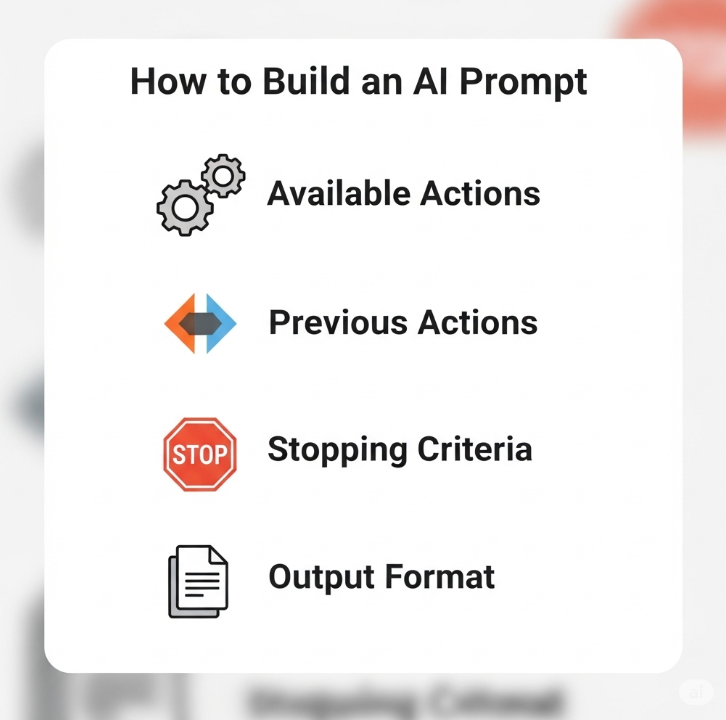

In [55]:
prompt_template = """
You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than {max_iterations} iterations for a given student question.
The current iteration number: {iteration_number}. If we exceed the allowed number 
of iterations, give the best possible answer with the provided information.

Output templates:

If you want to perform search, use this template:

{{
"action": "SEARCH",
"reasoning": "<add your reasoning here>",
"keywords": ["search query 1", "search query 2", ...]
}}

If you can answer the QUESTION using CONTEXT, use this template:

{{
"action": "ANSWER_CONTEXT",
"answer": "<your answer>",
"source": "CONTEXT"
}}

If the context doesn't contain the answer, use your own knowledge to answer the question

{{
"action": "ANSWER",
"answer": "<your answer>",
"source": "OWN_KNOWLEDGE"
}}

<QUESTION>
{question}
</QUESTION>

<SEARCH_QUERIES>
{search_queries}
</SEARCH_QUERIES>

<CONTEXT> 
{context}
</CONTEXT>

<PREVIOUS_ACTIONS>
{previous_actions}
</PREVIOUS_ACTIONS>
""".strip()

Este `prompt_template` está diseñado para un modelo de lenguaje que actúa como un **asistente de enseñanza**. Su tarea es ayudar a responder preguntas de estudiantes usando tres fuentes posibles: su propio conocimiento, documentos recuperados de una base de datos de preguntas frecuentes (FAQ), o realizando nuevas búsquedas en dicha base.

#### ¿Qué hace este prompt?

1. **Define el contexto y reglas del asistente:**
   - Recibe una `QUESTION` del estudiante.
   - Usa un bloque de `CONTEXT` que se construye a partir de documentos obtenidos desde una base de datos FAQ.
   - Las `SEARCH_QUERIES` indican las búsquedas previas utilizadas para armar el contexto.
   - `PREVIOUS_ACTIONS` registra las acciones ya realizadas por el asistente.

2. **Acciones permitidas por el modelo:**
   - **SEARCH:** Buscar nuevos documentos relevantes en la FAQ. Debe generar nuevas consultas que no se hayan usado antes, basadas en la pregunta y el contexto.
   - **ANSWER_CONTEXT:** Si el contexto contiene suficiente información, responde con base en él.
   - **ANSWER:** Si el contexto no es suficiente, responde usando su conocimiento interno.

3. **Control de iteraciones:**
   - No puede hacer más de `{max_iterations}` pasos por pregunta.
   - Si se alcanza el límite de iteraciones (`{iteration_number}`), debe dar la mejor respuesta posible con lo que tiene.

4. **Formato de salida esperado:**
   - Para búsqueda:
     ```json
     {
       "action": "SEARCH",
       "reasoning": "<explicación de por qué busca>",
       "keywords": ["consulta 1", "consulta 2", ...]
     }
     ```
   - Para respuesta con contexto:
     ```json
     {
       "action": "ANSWER_CONTEXT",
       "answer": "<respuesta>",
       "source": "CONTEXT"
     }
     ```
   - Para respuesta con conocimiento propio:
     ```json
     {
       "action": "ANSWER",
       "answer": "<respuesta>",
       "source": "OWN_KNOWLEDGE"
     }
     ```

#### En resumen

Este prompt guía al modelo a actuar de manera iterativa e informada para responder preguntas estudiantiles. Le permite **buscar documentos**, **usar contexto acumulado** o **responder directamente** según el estado actual, mientras evita repeticiones y respeta un número máximo de intentos.


Nuestro código se vuelve más complejo. Para la primera iteración, tenemos:

In [56]:
question = "how do I join the course?"

search_queries = []
search_results = []
previous_actions = []
context = build_context(search_results)

prompt = prompt_template.format(
    question=question,
    context=context,
    search_queries="\n".join(search_queries),
    previous_actions='\n'.join([json.dumps(a) for a in previous_actions]),
    max_iterations=3,
    iteration_number=1
)
print(prompt)

You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than 3 iterations for a given student question.
The current iteration number

In [57]:
answer_json = llm(prompt)
answer = json.loads(answer_json)
print(json.dumps(answer, indent=2))

{
  "action": "SEARCH",
  "reasoning": "I need to gather specific information about the process of joining the course, as there is no existing context regarding this topic.",
  "keywords": [
    "how to join the course",
    "enrollment process",
    "course registration"
  ]
}


Necesitamos guardar las acciones, así que hagámoslo:

In [58]:
previous_actions.append(answer)

Guardar las consultas de búsqueda:

In [59]:
keywords = answer['keywords']
search_queries.extend(keywords)

Guardar los resultados de las consultas de búsqueda:

In [60]:
for k in keywords:
    res = search(k)
    search_results.extend(res)

Algunos de los resultados de la búsqueda serán duplicados, por lo que debemos eliminarlos:

In [61]:
def dedup(seq):
    seen = set()
    result = []
    for el in seq:
        _id = el['_id']
        if _id in seen:
            continue
        seen.add(_id)
        result.append(el)
    return result

search_results = dedup(search_results)

Ahora hagamos otra iteración: usemos el mismo código que anteriormente, pero eliminemos la inicialización de la variable y aumentemos el número de iteración:

In [62]:
# question = "how do I join the course?"

# search_queries = []
# search_results = []
# previous_actions = []

context = build_context(search_results)

prompt = prompt_template.format(
    question=question,
    context=context,
    search_queries="\n".join(search_queries),
    previous_actions='\n'.join([json.dumps(a) for a in previous_actions]),
    max_iterations=3,
    iteration_number=2
)
print(prompt)

answer_json = llm(prompt)
answer = json.loads(answer_json)
print(json.dumps(answer, indent=2))

You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than 3 iterations for a given student question.
The current iteration number

Pongamos todo junto:

In [ ]:
question = "what do I need to do to be successful at module 1?"

search_queries = []
search_results = []
previous_actions = []


iteration = 0

while True:
    print(f'ITERATION #{iteration}...')

    context = build_context(search_results)
    prompt = prompt_template.format(
        question=question,
        context=context,
        search_queries="\n".join(search_queries),
        previous_actions='\n'.join([json.dumps(a) for a in previous_actions]),
        max_iterations=3,
        iteration_number=iteration
    )

    print(prompt)

    answer_json = llm(prompt)
    answer = json.loads(answer_json)
    print(json.dumps(answer, indent=2))

    previous_actions.append(answer)

    action = answer['action']
    if action != 'SEARCH':
        break

    keywords = answer['keywords']
    search_queries = list(set(search_queries) | set(keywords))
    
    for k in keywords:
        res = search(k)
        search_results.extend(res)

    search_results = dedup(search_results)
    
    iteration = iteration + 1
    if iteration >= 4:
        break

    print()

El código anterior la ponemos en un método

In [64]:
def agentic_search(question):
    search_queries = []
    search_results = []
    previous_actions = []

    iteration = 0
    
    while True:
        print(f'ITERATION #{iteration}...')
    
        context = build_context(search_results)
        prompt = prompt_template.format(
            question=question,
            context=context,
            search_queries="\n".join(search_queries),
            previous_actions='\n'.join([json.dumps(a) for a in previous_actions]),
            max_iterations=3,
            iteration_number=iteration
        )
    
        print(prompt)
    
        answer_json = llm(prompt)
        answer = json.loads(answer_json)
        print(json.dumps(answer, indent=2))

        previous_actions.append(answer)
    
        action = answer['action']
        if action != 'SEARCH':
            break
    
        keywords = answer['keywords']
        search_queries = list(set(search_queries) | set(keywords))

        for k in keywords:
            res = search(k)
            search_results.extend(res)
    
        search_results = dedup(search_results)
        
        iteration = iteration + 1
        if iteration >= 4:
            break
    
        print()

    return answer

In [65]:
agentic_search('how do I prepare for the course?')

ITERATION #0...
You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than 3 iterations for a given student question.
The current 

{'action': 'ANSWER',
 'answer': 'To prepare for the course, consider the following steps:\n\n1. **Understand the Schedule**: Know the exact start date (15th Jan 2024) and structure of the course. Familiarize yourself with the schedule and deadlines.\n\n2. **Register and Join Relevant Groups**: Ensure that you are registered for the course. Join the course’s communication channels such as Telegram and Slack for updates and community support. \n\n3. **Review Course Materials**: Although the course materials will be available after the end of the live session, starting to familiarize yourself with them can give you a head start. You can also look into the homeworks and prepare for the capstone project.\n\n4. **Set a Study Plan**: Time management is crucial. Allocate specific times to study, complete assignments, and review materials. This will help you stay organized and on track.\n\n5. **Practice Tools and Technologies**: Depending on the tools being used (like Git, GitHub, or specific d

## Function calling

### Llamado a Funciones en OpenAI

En versiones anteriores, toda la lógica necesaria debía incluirse directamente en el *prompt*.

Sin embargo, OpenAI y otros proveedores ahora ofrecen una API más flexible y poderosa para extender las capacidades del modelo con funcionalidades adicionales, como realizar búsquedas externas o consultar bases de datos.

🔗 [Documentación oficial sobre Function Calling](https://platform.openai.com/docs/guides/function-calling)

Esta funcionalidad se conoce como **"function calling"** (*llamado a funciones*): defines funciones que el modelo puede invocar según el contexto de la conversación. Si el modelo considera apropiado llamar a una función, devolverá una salida estructurada con los parámetros necesarios para su ejecución.

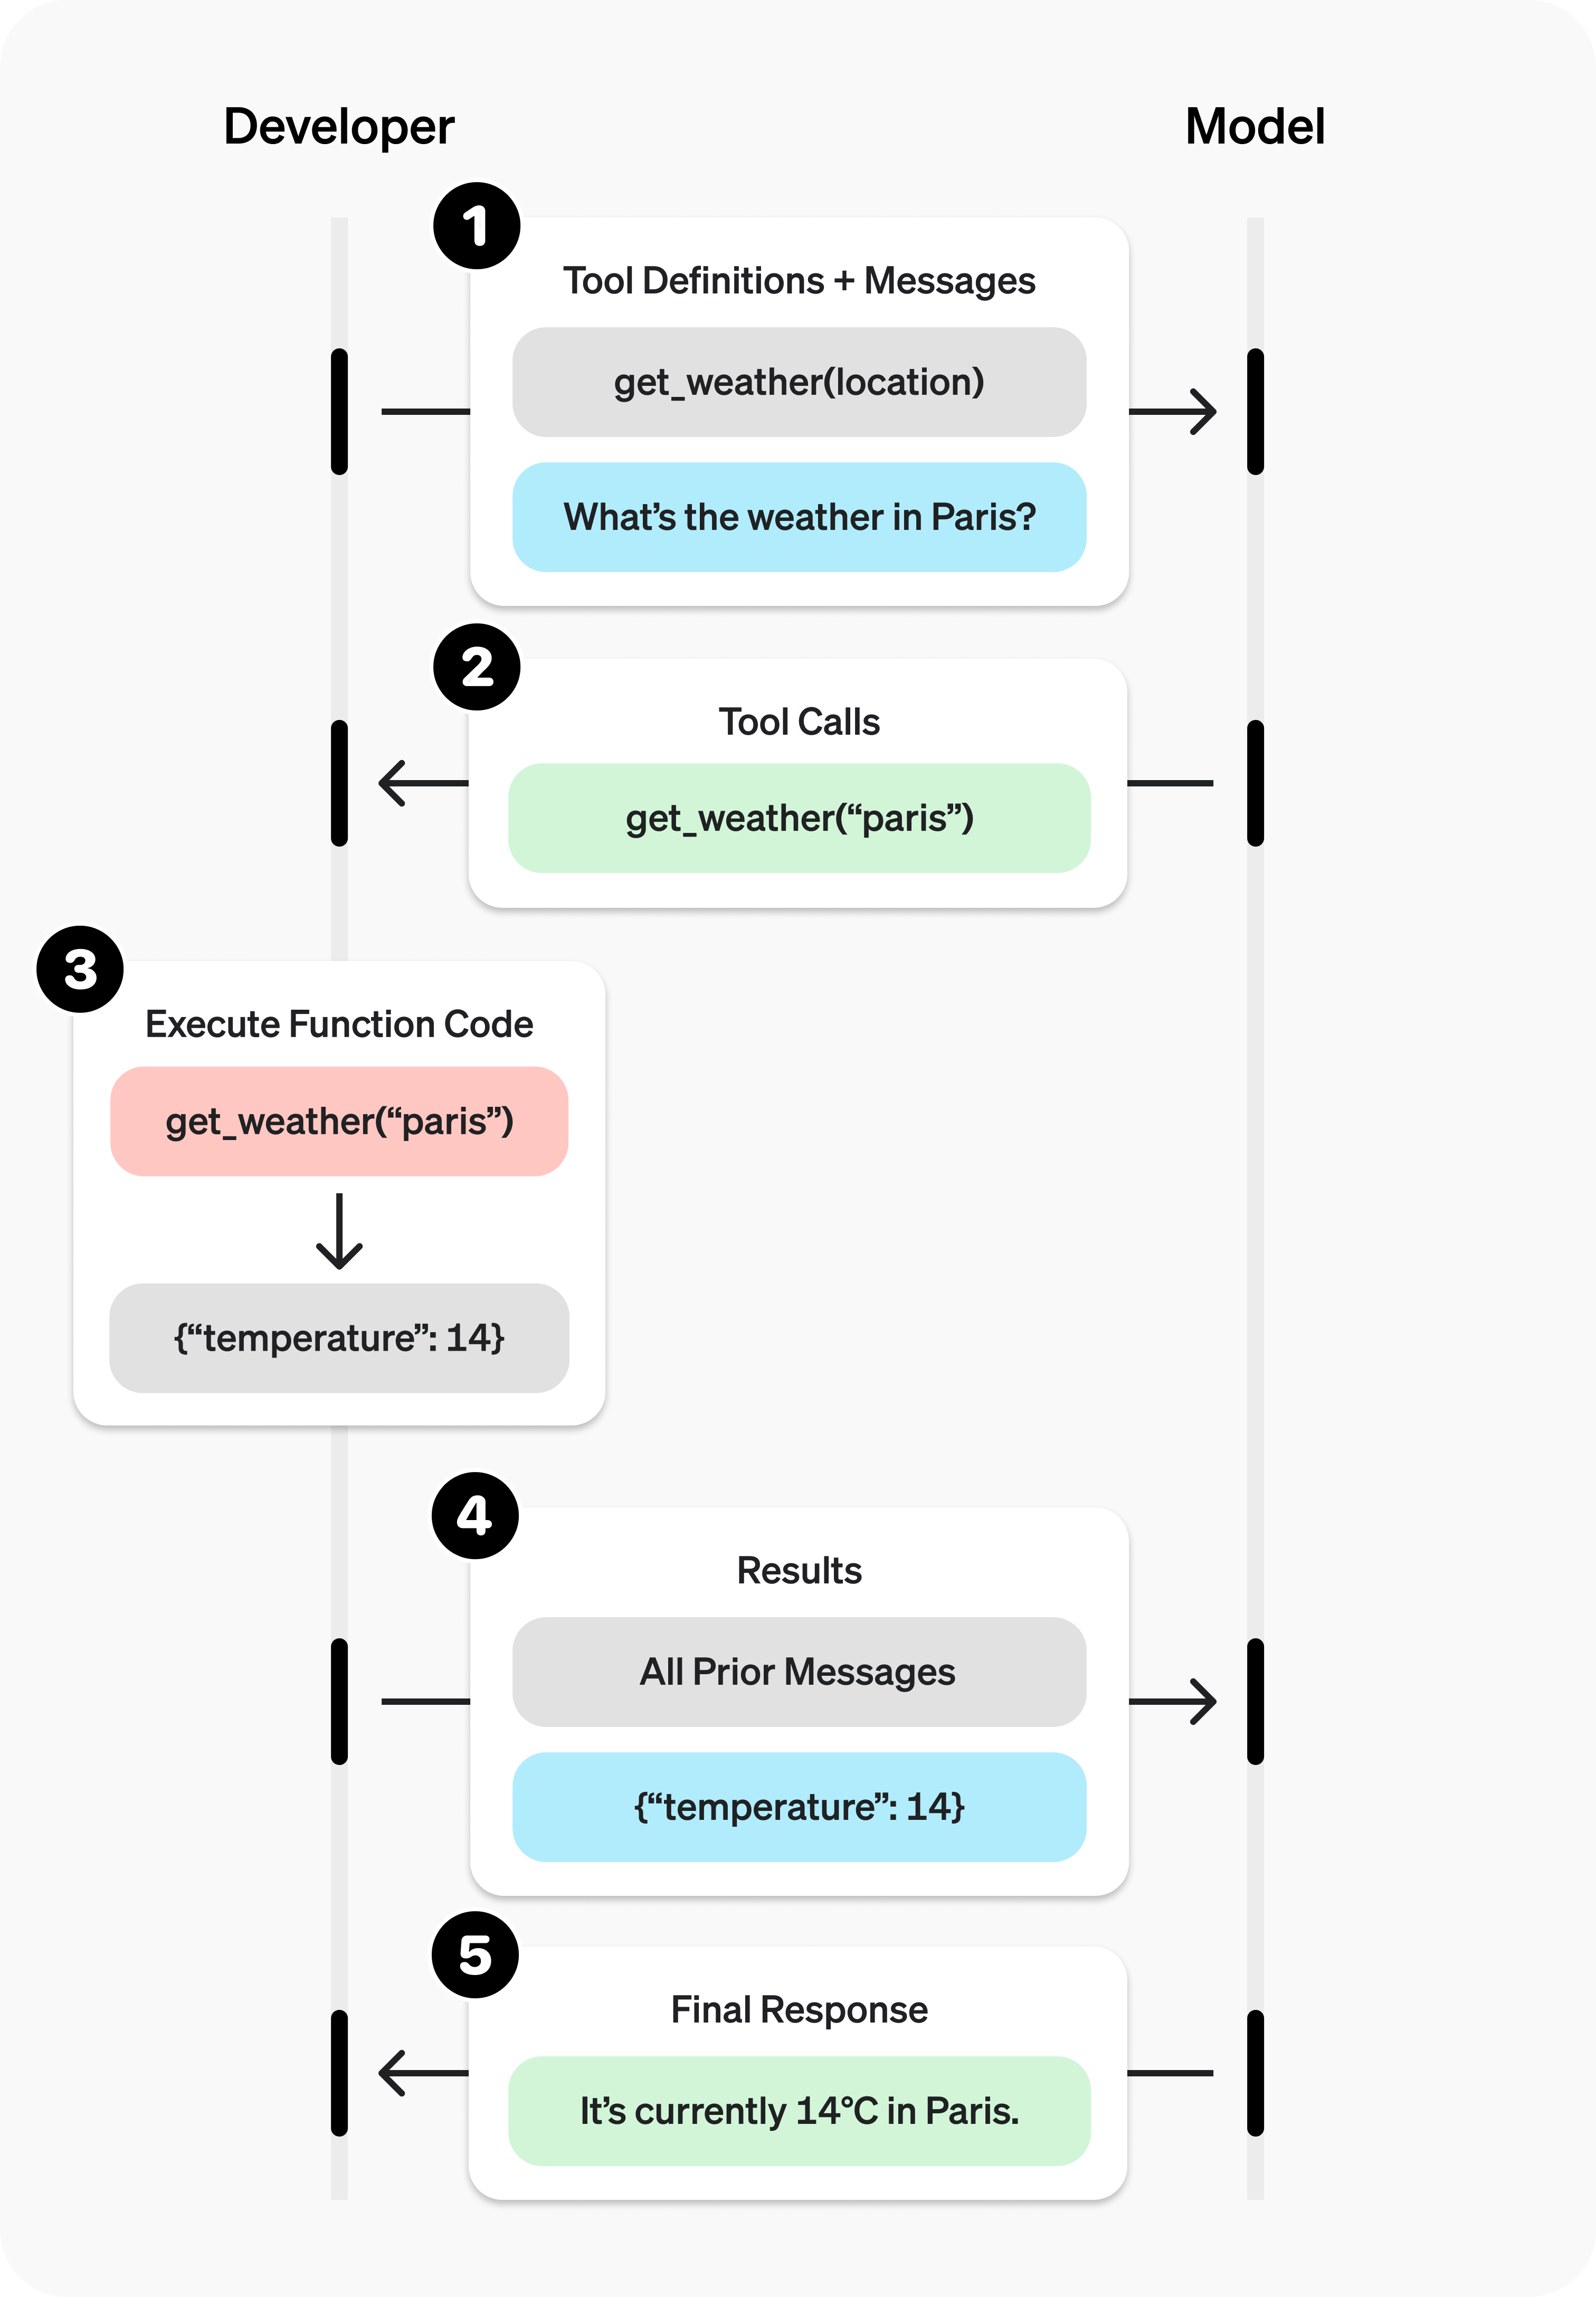

Por ejemplo, tomemos nuestra función de búsqueda:

In [1]:
def search(query):
    boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query=query,
        filter_dict={'course': 'data-engineering-zoomcamp'},
        boost_dict=boost,
        num_results=5,
        output_ids=True
    )

    return results

Lo describimos de la siguiente manera:

In [89]:
search_tool = {
    "type": "function",
    "name": "search",
    "description": "Search the FAQ database",
    "parameters": {
        "type": "object",
        "properties": {
            "query": {
                "type": "string",
                "description": "Search query text to look up in the course FAQ."
            }
        },
        "required": ["query"],
        "additionalProperties": False
    }
}

Aquí tenemos:

- **name**: `search`  
- **description**: cuándo utilizarla  
- **parameters**: todos los argumentos que la función puede recibir y su descripción  

Para poder usar *function calling*, utilizaremos una API más reciente: la API de **"responses"** (no la de **"chat completions"** como antes):

In [18]:
import json
from openai import OpenAI

client = OpenAI()

In [8]:
question = "How do I do well in module 1?"

developer_prompt = """
You're a course teaching assistant. 
You're given a question from a course student and your task is to answer it.
""".strip()

tools = [search_tool]

chat_messages = [
    {"role": "developer", "content": developer_prompt},
    {"role": "user", "content": question}
]

response = client.responses.create(
    model='gpt-4o-mini',
    input=chat_messages,
    tools=tools
)

response.output

[ResponseFunctionToolCall(arguments='{"query":"How to do well in module 1"}', call_id='call_sgNsqrTNHeoCPQbTj0RxPNz5', name='search', type='function_call', id='fc_688ffe5ef64881a3a7b1235c5d12bb6d07999b626201318c', status='completed')]

Si el modelo considera que se debe realizar una llamada a una función, nos lo indicará de la siguiente manera:
```
[ResponseFunctionToolCall(arguments='{"query":"How to do well in module 1"}', call_id='call_sgNsqrTNHeoCPQbTj0RxPNz5', name='search', type='function_call', id='fc_688ffe5ef64881a3a7b1235c5d12bb6d07999b626201318c', status='completed')]
```

Podemos saber el tipo, los argumentos que debemos pasar al metodo y el nombre del mismo:

In [13]:
response.output[0].type, response.output[0].arguments, response.output[0].name

('function_call', '{"query":"How to do well in module 1"}', 'search')

In [14]:
calls = response.output
call = calls[0]
call

ResponseFunctionToolCall(arguments='{"query":"How to do well in module 1"}', call_id='call_sgNsqrTNHeoCPQbTj0RxPNz5', name='search', type='function_call', id='fc_688ffe5ef64881a3a7b1235c5d12bb6d07999b626201318c', status='completed')

In [15]:
call_id = call.call_id
call_id

'call_sgNsqrTNHeoCPQbTj0RxPNz5'

In [16]:
f_name = call.name
f_name

'search'

In [20]:
arguments = json.loads(call.arguments)
arguments, type(arguments)

({'query': 'How to do well in module 1'}, dict)

Hagamos una llamada a la función `search`.  
Usando `f_name`, podemos identificar la función que necesitamos ejecutar.

Para esto, utilizamos `f = globals()`, que nos permite acceder a todas las funciones definidas en el ámbito global como un diccionario.  
De esta forma, podemos obtener una referencia a la función con `f[f_name]` y luego ejecutarla pasando los argumentos necesarios.


In [26]:
f = globals()

In [35]:
# descomenta y ejecuta para ver todo lo que se obtiene
#f

In [28]:
type(f)

dict

In [29]:
f = f[f_name]
f

<function __main__.search(query)>

In [32]:
results = f(**arguments)

In [34]:
search_results = json.dumps(results, indent=2)
print(search_results)

[
  {
    "text": "Even after installing pyspark correctly on linux machine (VM ) as per course instructions, faced a module not found error in jupyter notebook .\nThe solution which worked for me(use following in jupyter notebook) :\n!pip install findspark\nimport findspark\nfindspark.init()\nThereafter , import pyspark and create spark contex<<t as usual\nNone of the solutions above worked for me till I ran !pip3 install pyspark instead !pip install pyspark.\nFilter based on conditions based on multiple columns\nfrom pyspark.sql.functions import col\nnew_final.filter((new_final.a_zone==\"Murray Hill\") & (new_final.b_zone==\"Midwood\")).show()\nKrishna Anand",
    "section": "Module 5: pyspark",
    "question": "Module Not Found Error in Jupyter Notebook .",
    "course": "data-engineering-zoomcamp",
    "_id": 322
  },
  {
    "text": "You need to look for the Py4J file and note the version of the filename. Once you know the version, you can update the export command accordingly, th

Guardar tanto la respuesta como el resultado de la llamada a la función:

In [36]:
chat_messages.append(call)

chat_messages.append({
    "type": "function_call_output",
    "call_id": call.call_id,
    "output": search_results,
})

Ahora `chat_messages` contiene tanto la descripción de la llamada (para mantener el historial) como los resultados.

Vamos a hacer otra llamada al modelo:

In [38]:
len(chat_messages)

4

In [39]:
response = client.responses.create(
    model='gpt-4o-mini',
    input=chat_messages,
    tools=tools
)

Esta vez debería ser la respuesta `ResponseOutputMessage` (aunque también puede ser otra llamada `ResponseFunctionToolCall`):

In [43]:
response.output[0]

ResponseOutputMessage(id='msg_689002e8224481a39019e555d2e36bc107999b626201318c', content=[ResponseOutputText(annotations=[], text="To excel in Module 1 of your course, here are some tips:\n\n1. **Understand the Basics**: Ensure you're familiar with fundamental concepts related to Docker and Terraform, as these are key parts of Module 1.\n\n2. **Follow Instructions Carefully**: Make sure to follow all installation instructions closely to avoid common setup issues, such as module import errors.\n\n3. **Practice Coding**: Get hands-on with coding exercises. Try to replicate examples given in lecture materials, and don’t hesitate to experiment on your own.\n\n4. **Troubleshoot Common Errors**:\n   - If you encounter errors like `ModuleNotFoundError: No module named 'psycopg2'`, ensure that you have the required libraries installed: consider using `pip install psycopg2` or `conda install psycopg2`.\n   - If you face a `TypeError: 'module' object is not callable`, check your connection strin

In [53]:
r = response.output[0]

print(f"Pregunta: {question}")
print()
print(f"Respuesta:\n{r.content[0].text}")

Pregunta: How do I do well in module 1?

Respuesta:
To excel in Module 1 of your course, here are some tips:

1. **Understand the Basics**: Ensure you're familiar with fundamental concepts related to Docker and Terraform, as these are key parts of Module 1.

2. **Follow Instructions Carefully**: Make sure to follow all installation instructions closely to avoid common setup issues, such as module import errors.

3. **Practice Coding**: Get hands-on with coding exercises. Try to replicate examples given in lecture materials, and don’t hesitate to experiment on your own.

4. **Troubleshoot Common Errors**:
   - If you encounter errors like `ModuleNotFoundError: No module named 'psycopg2'`, ensure that you have the required libraries installed: consider using `pip install psycopg2` or `conda install psycopg2`.
   - If you face a `TypeError: 'module' object is not callable`, check your connection string and ensure you are correctly calling the `create_engine` function.

5. **Engage with th

### Realizando múltiples llamadas

*¿Qué pasa si queremos hacer múltiples llamadas?*

**Cambio en el `developer_prompt` para permitir múltiples llamadas**

Antes, el prompt indicaba simplemente que el asistente debía responder a una única pregunta de un estudiante, enfocándose en una sola interacción.

```
You're a course teaching assistant. 
You're given a question from a course student and your task is to answer it.
```

Con el nuevo prompt, se añade la instrucción de que si el asistente necesita buscar algo en una FAQ, debe convertir la pregunta del estudiante en múltiples consultas.

```
You're a course teaching assistant. 
You're given a question from a course student and your task is to answer it.
If you look up something in FAQ, convert the student question into multiple queries.
```

**¿Cómo ayuda esto a hacer múltiples llamadas?**

- Al dividir la pregunta original en varias consultas específicas, el modelo genera múltiples solicitudes que pueden ser enviadas como llamadas separadas a la API.

- Esto permite manejar preguntas complejas o con varios subtemas de forma más eficiente y precisa.

- Cada llamada puede recuperar información diferente o complementar la respuesta, facilitando un flujo de trabajo dinámico basado en múltiples interacciones.

- Así, en lugar de una única llamada que intenta responder todo, se puede construir la respuesta final agregando los resultados de varias llamadas.

Este enfoque es ideal para sistemas que requieren combinar información de distintas fuentes o etapas antes de entregar una respuesta completa.



In [54]:
developer_prompt = """
You're a course teaching assistant. 
You're given a question from a course student and your task is to answer it.
If you look up something in FAQ, convert the student question into multiple queries.
""".strip()

chat_messages = [
    {"role": "developer", "content": developer_prompt},
    {"role": "user", "content": question}
]

In [55]:
response = client.responses.create(
    model='gpt-4o-mini',
    input=chat_messages,
    tools=tools
)

In [62]:
len(response.output), response.output

(3,
 [ResponseFunctionToolCall(arguments='{"query":"how to do well in module 1"}', call_id='call_bHdg16iSCmll0fqUabyWYKsV', name='search', type='function_call', id='fc_68900b41b428819e96c5e4b385604b9b01c8be6377c9dfb7', status='completed'),
  ResponseFunctionToolCall(arguments='{"query":"module 1 study tips"}', call_id='call_Y7agBt29pkC1TbqkB13qD5Uo', name='search', type='function_call', id='fc_68900b422610819e901ca9d2b9d62f0301c8be6377c9dfb7', status='completed'),
  ResponseFunctionToolCall(arguments='{"query":"module 1 assessment criteria"}', call_id='call_yL3Uf1tia0M3LVb5QtjKMrob', name='search', type='function_call', id='fc_68900b4266f0819e897f839aa0a836c301c8be6377c9dfb7', status='completed')])

Esta vez, vamos a comenzar a organizar un poco el código.

Primero, crea una función llamada `do_call`:

La función `do_call` ejecuta dinámicamente una función a partir de una llamada definida por el modelo (tool call). 

1. **Obtiene el nombre de la función** desde el objeto `tool_call_response`.
2. **Convierte los argumentos** (que vienen como cadena JSON) a un diccionario de Python.
3. **Busca la función en el entorno global** usando `globals()` y la ejecuta con los argumentos extraídos.
4. **Devuelve un diccionario** con el resultado de la ejecución, incluyendo el `call_id` original y la salida formateada en JSON.

Esto permite automatizar la ejecución de funciones solicitadas por el modelo, manteniendo trazabilidad de cada llamada.

In [63]:
def do_call(tool_call_response):
    function_name = tool_call_response.name
    arguments = json.loads(tool_call_response.arguments)

    f = globals()[function_name]
    result = f(**arguments)

    return {
        "type": "function_call_output",
        "call_id": tool_call_response.call_id,
        "output": json.dumps(result, indent=2),
    }

Ahora procesamos cada entrada en la salida del modelo.

**¿Qué hace el siguiente fragmento?**

- Recorre cada elemento generado por el modelo en su respuesta.
- Agrega cada entrada al historial de conversación (`chat_messages`) y muestra su tipo (por ejemplo, llamada a función o mensaje).
- Si la entrada es una llamada a función, se ejecuta con `do_call` y su resultado también se añade al historial.
- Si la entrada es un mensaje de texto, se imprime directamente.

Este flujo permite manejar tanto las respuestas del modelo como las llamadas a funciones, manteniendo el historial actualizado y listo para la siguiente interacción.

In [64]:
for entry in response.output:
    chat_messages.append(entry)
    print(entry.type)

    if entry.type == 'function_call':      
        result = do_call(entry)
        chat_messages.append(result)
    elif entry.type == 'message':
        print(entry.text)

function_call
function_call
function_call


Probablemente la primera llamada sea una llamada a función, así que hagamos otra más.

**¿Por qué hacer otra llamada?**

La primera interacción del modelo suele generar una llamada a función para obtener datos o realizar una acción específica. Una vez que esa función ha sido ejecutada y el resultado se ha agregado al historial (`chat_messages`), es necesario hacer una nueva llamada al modelo para que procese ese resultado y genere una respuesta completa o decida el siguiente paso (como continuar la conversación o hacer otra llamada).

Esto permite mantener un flujo interactivo y dinámico entre el modelo, las herramientas y el usuario.

In [65]:
response = client.responses.create(
    model='gpt-4o-mini',
    input=chat_messages,
    tools=tools
)

for entry in response.output:
    chat_messages.append(entry)
    print(entry.type)
    print()

    if entry.type == 'function_call':      
        result = do_call(entry)
        chat_messages.append(result)
    elif entry.type == 'message':
        print(entry.content[0].text) 

message

To do well in Module 1, here are some strategies based on common challenges and best practices:

1. **Understand the Course Material**: Focus on the key concepts covered in the module, especially around Docker and Terraform.
   
2. **Hands-On Practice**: Ensure you set up all the necessary environments and tools as outlined. Pay special attention to:
   - Installing required Python modules, such as `psycopg2` and using SQLAlchemy correctly. If you encounter issues, refer to the error messages and solutions like running `pip install psycopg2-binary`.

3. **Follow Instructions Carefully**: If the module specifies certain commands to run, such as setting up a `Dockerfile`, follow them precisely. Missing a step can lead to errors like "ModuleNotFoundError" or "TypeError".

4. **Engage in Discussions**: If you encounter difficulties, don't hesitate to ask questions in discussion forums or study groups.

5. **Review Assessment Criteria**: Familiarize yourself with the grading rubric

**Poniendo todo junto**

El prompt queda de la siguiente forma:

1. Uso estratégico de la FAQ:
   En lugar de simplemente sugerir consultar la FAQ si no se tiene suficiente conocimiento, ahora se instruye explícitamente al modelo a usarla como fuente secundaria cuando su conocimiento no es suficiente.

2. Exploración profunda del tema:
   Se añade una estrategia de búsqueda más avanzada. El modelo debe:
   - Hacer una primera consulta general a la FAQ.
   - Luego, basándose en los resultados obtenidos, realizar consultas adicionales para explorar el tema en mayor profundidad.
   Esto promueve un razonamiento iterativo y la obtención de respuestas más completas y precisas.

3. Pregunta de seguimiento al final:
   Cada respuesta debe finalizar con una pregunta de seguimiento relevante, fomentando una conversación más fluida, natural y centrada en el aprendizaje.  
   Esto no solo mejora la experiencia del usuario, sino que también ayuda a descubrir posibles dudas o temas relacionados.

In [95]:
developer_prompt = """
You're a course teaching assistant. 
You're given a question from a course student and your task is to answer it.

Use FAQ if your own knowledge is not sufficient to answer the question.
When using FAQ, perform deep topic exploration: make one request to FAQ,
and then based on the results, make more requests.

At the end of each response, ask the user a follow up question based on your answer.
""".strip()



chat_messages = [
    {"role": "developer", "content": developer_prompt},
]

Vamos a estructurar la lógica en dos bucles:

1. Bucle principal de preguntas y respuestas:
   Este ciclo espera una pregunta del usuario, la envía al modelo y gestiona el flujo general de la conversación. Si el usuario escribe `stop`, el ciclo se detiene.

2. Bucle de solicitudes al modelo:
   Una vez enviada una pregunta, este segundo ciclo se encarga de interactuar con la API de forma continua hasta obtener una respuesta final del modelo.  
   Si el modelo responde con una o varias llamadas a funciones (`function_call`), estas se ejecutan una por una y se agregan sus resultados al historial.  
   Luego, se vuelve a consultar al modelo con el historial actualizado, hasta que finalmente responde con un mensaje completo (texto para el usuario).

In [70]:
while True: # main Q&A loop
    question = input() # How do I do my best for module 1
    if question == 'stop':
        break

    message = {"role": "user", "content": question}
    chat_messages.append(message)

    while True: # request-response loop - query API till get a message
        response = client.responses.create(
            model='gpt-4o-mini',
            input=chat_messages,
            tools=tools
        )

        has_tool_calls = False
        
        for entry in response.output:
            chat_messages.append(entry)
        
            if entry.type == 'function_call':      
                print('function_call:', entry)
                print()
                result = do_call(entry)
                chat_messages.append(result)
                has_tool_calls = True

            elif entry.type == 'message':
                print(entry.content[0].text)
                print()

        if not has_tool_calls:
            break

 How do I do my best for module 1


function_call: ResponseFunctionToolCall(arguments='{"query":"best practices for module 1"}', call_id='call_fbiXUICbMIPiQxJM5GnLeaI9', name='search', type='function_call', id='fc_689019cb52dc819e921831d32ab892ee01c8be6377c9dfb7', status='completed')

function_call: ResponseFunctionToolCall(arguments='{"query":"module 1 assessment criteria"}', call_id='call_4N9maUKGNyj041waR0HDkVs4', name='search', type='function_call', id='fc_689019cb9cd0819e8430fe94264c7c5c01c8be6377c9dfb7', status='completed')

function_call: ResponseFunctionToolCall(arguments='{"query":"module 1 study strategies"}', call_id='call_pTajXabma0DSjETXo1RzR8Pc', name='search', type='function_call', id='fc_689019cbd818819e8a5db0493f49990801c8be6377c9dfb7', status='completed')

To do your best in **Module 1**, here are some effective strategies:

### 1. **Understand Core Concepts**:
   - Focus on the principles of **Docker** and **Terraform**. Make sure you understand their roles in the course.

### 2. **Follow Best Practice

 stop


Hagámoslo un poco más bonito usando HTML:

In [86]:
from IPython.display import display, HTML
import markdown

**¿Qué hace la función `display_function_call`?**

Esta función genera una visualización interactiva en HTML para mostrar detalles de una llamada a función:

- **Muestra un resumen colapsable** con el nombre de la función y sus argumentos (acortados).
- **Dentro del panel desplegable**, presenta:
  - La llamada completa (`entry`) con todos sus datos.
  - El resultado de la ejecución (`result['output']`).
- Usa `display(HTML(...))` para renderizar el contenido en entornos como notebooks de Jupyter.


In [81]:
def shorten(text, max_length=50):
    if len(text) <= max_length:
        return text

    return text[:max_length - 3] + "..."

def display_function_call(entry, result):
    call_html = f"""
        <details>
        <summary>Function call: <tt>{entry.name}({shorten(entry.arguments)})</tt></summary>
        <div>
            <b>Call</b>
            <pre>{entry}</pre>
        </div>
        <div>
            <b>Output</b>
            <pre>{result['output']}</pre>
        </div>
        </details>
    """
    display(HTML(call_html))

La función `display_response` recibe un objeto `entry` y realiza lo siguiente:

- Convierte el texto en formato Markdown contenido en `entry.content[0].text` a HTML usando la librería `markdown`.
- Construye un bloque HTML que incluye un título **Assistant:** y el contenido ya convertido a HTML.
- Muestra este bloque HTML en una celda de Jupyter Notebook (o entorno compatible) usando la función `display` de IPython.

In [82]:
def display_response(entry):
    response_html = markdown.markdown(entry.content[0].text)
    html = f"""
        <div>
            <div><b>Assistant:</b></div>
            <div>{response_html}</div>
        </div>
    """
    display(HTML(html))

In [96]:
chat_messages = [
    {"role": "developer", "content": developer_prompt},
]

# Chat loop
while True:
    question = input()    
    
    if question.strip().lower() == 'stop':
        print("Chat ended.")
        break

    message = {"role": "user", "content": question}
    chat_messages.append(message)

    while True:  # inner request loop
        response = client.responses.create(
            model='gpt-4o-mini',
            input=chat_messages,
            tools=tools
        )
        
        has_messages = False

        for entry in response.output:
            chat_messages.append(entry)

            if entry.type == "function_call":
                result = do_call(entry)
                chat_messages.append(result)
                display_function_call(entry, result)

            elif entry.type == "message":
                display_response(entry)
                has_messages = True

        if has_messages:
            break

 How do I do my best for module 1


 stop


Chat ended.


In [94]:
developer_prompt

"You're a course teaching assistant. \nYou're given a question from a course student and your task is to answer it.\n\nUse FAQ if your own knowledge is not sufficient to answer the question.\n\nAt the end of each response, ask the user a follow up question based on your answer."

### Usando múltiples herramientas

¿Qué pasa si también queremos usar esta aplicación de chat para agregar nuevas entradas a las preguntas frecuentes (FAQ)? Necesitaremos otra función para ello:


In [73]:
def add_entry(question, answer):
    doc = {
        'question': question,
        'text': answer,
        'section': 'user added',
        'course': 'data-engineering-zoomcamp'
    }
    index.append(doc)

In [74]:
add_entry_description = {
    "type": "function",
    "name": "add_entry",
    "description": "Add an entry to the FAQ database",
    "parameters": {
        "type": "object",
        "properties": {
            "question": {
                "type": "string",
                "description": "The question to be added to the FAQ database",
            },
            "answer": {
                "type": "string",
                "description": "The answer to the question",
            }
        },
        "required": ["question", "answer"],
        "additionalProperties": False
    }
}

Podemos simplemente reutilizar el código anterior. Pero también podemos **limpiarlo y hacerlo más modular**.

Consulta el resultado en `chat_assistant.py`.

Puedes descargarlo usando `wget`:

In [77]:
! wget https://raw.githubusercontent.com/alexeygrigorev/rag-agents-workshop/refs/heads/main/chat_assistant.py

--2025-08-04 00:05:49--  https://raw.githubusercontent.com/alexeygrigorev/rag-agents-workshop/refs/heads/main/chat_assistant.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3495 (3.4K) [text/plain]
Saving to: ‘chat_assistant.py’

chat_assistant.py   100%[===================>]   3.41K  --.-KB/s    in 0s      

2025-08-04 00:05:49 (29.8 MB/s) - ‘chat_assistant.py’ saved [3495/3495]



**Aquí definimos múltiples clases:**

**`Tools` – Administra las funciones que el agente puede usar**
- `add_tool(function, description)`: Registra una función junto con su descripción.
- `get_tools()`: Devuelve una lista de las descripciones de funciones registradas.
- `function_call(tool_call_response)`: Ejecuta una llamada a función y devuelve el resultado.

**`ChatInterface` – Maneja la entrada del usuario y el formato de salida**
- `input()`: Obtiene la entrada del usuario.
- `display(message)`: Muestra un mensaje por consola.
- `display_function_call(entry, result)`: Muestra las llamadas a funciones en formato HTML.
- `display_response(entry)`: Muestra las respuestas del asistente en Markdown.

**`ChatAssistant` – Orquestador principal de la conversación**
- `__init__(tools, developer_prompt, chat_interface, client)`: Inicializa el asistente.
- `gpt(chat_messages)`: Realiza llamadas a la API de OpenAI.
- `run()`: Bucle principal del chat que maneja entradas del usuario y respuestas del asistente.


In [78]:
import chat_assistant

tools = chat_assistant.Tools()
tools.add_tool(search, search_tool)

tools.get_tools()

[{'type': 'function',
  'name': 'search',
  'description': 'Search the FAQ database',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string',
     'description': 'Search query text to look up in the course FAQ.'}},
   'required': ['query'],
   'additionalProperties': False}}]

In [79]:
developer_prompt = """
You're a course teaching assistant. 
You're given a question from a course student and your task is to answer it.

Use FAQ if your own knowledge is not sufficient to answer the question.

At the end of each response, ask the user a follow up question based on your answer.
""".strip()

chat_interface = chat_assistant.ChatInterface()

chat = chat_assistant.ChatAssistant(
    tools=tools,
    developer_prompt=developer_prompt,
    chat_interface=chat_interface,
    client=client
)

In [80]:
chat.run()

You: How do I do my best for module 1?


You: stop


Chat ended.


Para que el asistente pueda realizar una nueva acción (por ejemplo, **agregar entradas a una FAQ**), debemos registrar una nueva función utilizando el método `add_tool()` de la clase `Tools`.

In [83]:
tools.add_tool(add_entry, add_entry_description)
tools.get_tools()

[{'type': 'function',
  'name': 'search',
  'description': 'Search the FAQ database',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string',
     'description': 'Search query text to look up in the course FAQ.'}},
   'required': ['query'],
   'additionalProperties': False}},
 {'type': 'function',
  'name': 'add_entry',
  'description': 'Add an entry to the FAQ database',
  'parameters': {'type': 'object',
   'properties': {'question': {'type': 'string',
     'description': 'The question to be added to the FAQ database'},
    'answer': {'type': 'string', 'description': 'The answer to the question'}},
   'required': ['question', 'answer'],
   'additionalProperties': False}}]

In [84]:
chat.run()

You: How do I do well for module 1?


You: Add this back to FAQ


You: stop


Chat ended.


In [85]:
index.docs[-1]

{'question': 'How do I do well for module 1?',
 'text': 'To do well in Module 1, focusing on Docker and Terraform, follow these tips: 1. **Understand Key Concepts**: Ensure you grasp the fundamental concepts of Docker and Terraform. Review the course materials and documentation. 2. **Hands-on Practice**: Set up a local environment using Docker. Try to recreate course examples and modify them. 3. **Follow Instructions Carefully**: Pay attention to installation steps, particularly for dependencies like `psycopg2`. 4. **Utilize Community Resources**: Engage with peers in forums or study groups to share challenges and solutions. 5. **Check for Common Errors**: Familiarize yourself with common errors like "ModuleNotFoundError" and learn how to troubleshoot them. 6. **Stay Organized**: Keep your code and projects organized for easier reference.',
 'section': 'user added',
 'course': 'data-engineering-zoomcamp'}